In [1]:
# Import necessary libraries
from pathlib import Path
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import shutil, re, numpy as np
from kagglehub import dataset_download

RAW_DIR = Path("data/raw"); RAW_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("reports/eda/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)


c:\Users\LENOVO\Desktop\Project\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### 1 Download dataset (runs once)

expected = [RAW_DIR / name for name in [
    "events.csv", "category_tree.csv",
    "item_properties_part1.csv", "item_properties_part2.csv",
]]

if not all(f.exists() for f in expected):
    print("Downloading Retail Rocket CSVs…")
    dl = Path(dataset_download("retailrocket/ecommerce-dataset"))
    for csv in dl.glob("*.csv"):
        shutil.copy2(csv, RAW_DIR / csv.name)
    print("✔️ Done →", RAW_DIR)
else:
    print("CSVs already present →", RAW_DIR)


CSVs already present → data\raw


In [4]:
### 2 Load `events.csv` with memory‑friendly dtypes

dtypes = {
    "event_type": "category",
    "categoryid": "Int64",
    "item_id": "Int32",
    "visitorid": "Int32",
}

events = pd.read_csv(RAW_DIR / "events.csv", dtype=dtypes)
# Convert Unix‑ms → datetime
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")
print(f"Events: {len(events):,} rows | RAM {events.memory_usage(deep=True).sum()/1e6:.1f} MB")

# Determine the actual category column name
CAT_COL = "categoryid" if "categoryid" in events.columns else "category_id"

Events: 2,756,101 rows | RAM 248.6 MB


Saved → reports\eda\figures\daily_volume.png


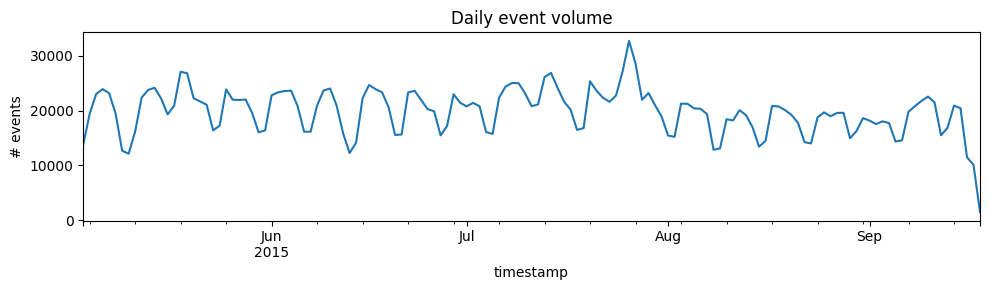

In [ ]:
### 3 Daily event volume (time series)

# Plot daily event volume
fig_path = FIG_DIR / "daily_volume.png"
fig, ax = plt.subplots(figsize=(10, 3))
(events.set_index("timestamp").resample("D").size()
       .plot(ax=ax, title="Daily event volume"))
ax.set_ylabel("# events")
fig.tight_layout(); fig.savefig(fig_path, dpi=120)
print("Saved →", fig_path)